In [1]:
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import os
import copy

In [2]:
def get_images(directory: str, output_shape: tuple):
    assert len(output_shape) == 2
    # Read in pokemon images
    images = []
    for img in os.listdir(directory): 
        #print(os.path.join(DIR, img))
        image = cv2.imread(os.path.join(directory, img), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
        image = cv2.resize(image, dsize=output_shape)
        images.append(image)
    images = np.stack(images)
    return images

def set_transparency_from_RGBA(img: np.ndarray, 
                               transparency_color: tuple = (0,0,0)):
    assert len(img.shape) == 3
    assert img.shape[2] == 4
    assert len(transparency_color) == 3
    img = copy.deepcopy(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x][y][3] == 0:
                img[x][y][0] = transparency_color[0]
                img[x][y][1] = transparency_color[1]
                img[x][y][2] = transparency_color[2]
    return img

def convertRGBA2RGB(img: np.ndarray):
    assert len(img.shape) == 3
    assert img.shape[2] == 4
    img = copy.deepcopy(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    return img

def compress_color(img: np.ndarray, compression: int = 1):
    assert len(img.shape) == 3
    assert compression != 0
    img = copy.deepcopy(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x][y][0] != 255 and img[x][y][1] != 255 
            and img[x][y][2] != 255:
                img[x][y][0] = (img[x][y][0]//compression)*compression
                img[x][y][1] = (img[x][y][1]//compression)*compression
                img[x][y][2] = (img[x][y][2]//compression)*compression
    return img

def is_gray(r,g,b):
    return (r == g and g == b)

def is_black(r,g,b):
    return (r == 0 and g == 0 and b == 0)

def is_white(r,g,b):
    return (r == 255 and g == 255 and b == 255)

def get_color_dict(img: np.ndarray, compression: int = 1, 
                   omit_black: bool = True, omit_white: bool = True, 
                   omit_gray: bool = False):
    assert len(img.shape) == 3
    assert compression != 0
    img = copy.deepcopy(img)
    color_dict = {}
    total = 0
    for r in range(256//compression):
        for g in range(256//compression):
            for b in range(256//compression):
                color_dict[(r*compression, g*compression, 
                            b*compression)] = 0
    color_dict[(255,255,255)] = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            color = (img[x][y][0], img[x][y][1], img[x][y][2])
            if (not ((omit_black and is_black(color[0],color[1],color[2])) 
                     or (omit_white and is_white(color[0],color[1],
                                                 color[2])) 
                     or (omit_gray and is_gray(color[0],color[1],
                                               color[2])))):
                if color in color_dict:
                    color_dict[color] = color_dict[color] + 1
                    total = total + 1
    color_dict = {k: v for k, v in sorted(color_dict.items(), 
                                          key=lambda item: item[1])}
    ret_dict = {'color_dict': color_dict, 'total': total}
    return ret_dict

def rgbtohex(r, g, b):
    return int('%02x%02x%02x'%(r,g,b), 16)

In [3]:
compression = 64
DIR = 'pokemons/'
image_shape = (43,43)

In [4]:
images = get_images(DIR, image_shape)
for i in range(len(images)):
    img = set_transparency_from_RGBA(images[i])
    images[i] = img

In [5]:
temp_imgs = []
for i in range(len(images)):
    img = convertRGBA2RGB(images[i])
    temp_imgs.append(img)
images = np.stack(temp_imgs)

In [6]:
temp_imgs = []
for i in range(len(images)):
    img = compress_color(images[i],compression)
    temp_imgs.append(img)
images = np.stack(temp_imgs)

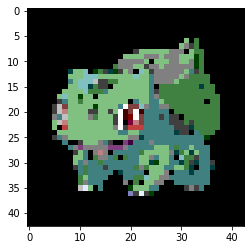

In [7]:
plt.imshow(images[0])

In [8]:
color_dicts = []
for i in range(len(images)):
    color_dict = get_color_dict(images[i],compression,omit_gray=True)
    color_dicts.append(color_dict)

In [9]:
dict_size = len(color_dicts[0]['color_dict'])
column_names = []
for r in range(256//compression):
    for g in range(256//compression):
        for b in range(256//compression):
            column_names.append(hex(rgbtohex(r*compression,g*compression,
                                             b*compression)))
if(column_names[-1] != hex(rgbtohex(255,255,255))):
    column_names.append(hex(rgbtohex(255,255,255)))

In [10]:
assert len(column_names) == dict_size

column_dict = {}
for name in column_names:
    new_column = []
    column_dict[name] = new_column
    
for color_dict in color_dicts:
    total = color_dict['total']
    cdict = color_dict['color_dict']
    for color, value in cdict.items():
        color_name = hex(rgbtohex(color[0],color[1],color[2]))
        column_dict[color_name].append(value/total)

In [11]:
data = pd.read_csv("pokemon_img_20by20_types.csv", index_col=0)
data = data.drop(data.columns.to_series()["p0000":"p1599"], axis=1)
for key, value in column_dict.items():
    data[key] = value

In [12]:
data

,id,name,species,type1,type2,gen,Normal,Fighting,Flying,Poison,...,0xc040c0,0xc08000,0xc08040,0xc08080,0xc080c0,0xc0c000,0xc0c040,0xc0c080,0xc0c0c0,0xffffff
0,1,Bulbasaur,Seed Pokemon,Grass,Poison,1,0,0,0,1,...,0.0,0.000000,0.000000,0.006814,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,2,Ivysaur,Seed Pokemon,Grass,Poison,1,0,0,0,1,...,0.0,0.000000,0.000000,0.052427,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,3,Venusaur,Seed Pokemon,Grass,Poison,1,0,0,0,1,...,0.0,0.000000,0.002469,0.086420,0.014815,0.0,0.000000,0.004938,0.0,0.0
3,4,Charmander,Lizard Pokemon,Fire,NaN,1,0,0,0,0,...,0.0,0.000000,0.417790,0.080863,0.002695,0.0,0.032345,0.099730,0.0,0.0
4,5,Charmeleon,Flame Pokemon,Fire,NaN,1,0,0,0,0,...,0.0,0.002857,0.097143,0.048571,0.000000,0.0,0.031429,0.082857,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,797,Celesteela,Launch Pokemon,Steel,Flying,7,0,0,1,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.018051,0.050542,0.0,0.0
797,798,Kartana,Drawn Sword Pokemon,Grass,Steel,7,0,0,0,0,...,0.0,0.040000,0.070000,0.000000,0.000000,0.1,0.030000,0.000000,0.0,0.0
798,799,Guzzlord,Junkivore Pokemon,Dark,Dragon,7,0,0,0,0,...,0.0,0.009662,0.033816,0.000000,0.000000,0.0,0.173913,0.024155,0.0,0.0
799,800,Necrozma,Prism Pokemon,Psychic,NaN,7,0,0,0,0,...,0.0,0.000000,0.000000,0.150000,0.000000,0.0,0.000000,0.150000,0.0,0.0


In [13]:
DIR = "gen8/"

In [14]:
images = get_images(DIR, image_shape)
for i in range(len(images)):
    img = set_transparency_from_RGBA(images[i])
    images[i] = img

In [15]:
temp_imgs = []
for i in range(len(images)):
    img = convertRGBA2RGB(images[i])
    temp_imgs.append(img)
images = np.stack(temp_imgs)

In [16]:
temp_imgs = []
for i in range(len(images)):
    img = compress_color(images[i],compression)
    temp_imgs.append(img)
images = np.stack(temp_imgs)

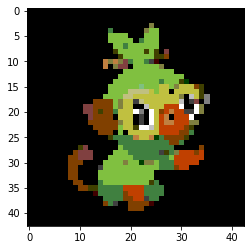

In [17]:
plt.imshow(images[0])

In [18]:
color_dicts = []
for i in range(len(images)):
    color_dict = get_color_dict(images[i],compression, omit_gray=True)
    color_dicts.append(color_dict)

In [19]:
dict_size = len(color_dicts[0]['color_dict'])
column_names = []
for r in range(256//compression):
    for g in range(256//compression):
        for b in range(256//compression):
            column_names.append(hex(rgbtohex(r*compression,g*compression,b*compression)))
if(column_names[-1] != hex(rgbtohex(255,255,255))):
    column_names.append(hex(rgbtohex(255,255,255)))

In [20]:
assert len(column_names) == dict_size

column_dict = {}
for name in column_names:
    new_column = []
    column_dict[name] = new_column
    
for color_dict in color_dicts:
    total = color_dict['total']
    cdict = color_dict['color_dict']
    for color, value in cdict.items():
        color_name = hex(rgbtohex(color[0],color[1],color[2]))
        column_dict[color_name].append(value/total)

In [21]:
trainX = data.loc[:, '0x0':]
trainYs = data.loc[:, 'Normal':'Fairy']
testX = trainX.iloc[0:0]
for key, value in column_dict.items():
    testX[key] = value

c:\users\brand\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
trainX

,0x0,0x40,0x80,0xc0,0x4000,0x4040,0x4080,0x40c0,0x8000,0x8040,...,0xc040c0,0xc08000,0xc08040,0xc08080,0xc080c0,0xc0c000,0xc0c040,0xc0c080,0xc0c0c0,0xffffff
0,0.0,0.000000,0.0,0.0,0.018739,0.027257,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.006814,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.011650,0.0,0.0,0.005825,0.083495,0.011650,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.052427,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.004938,0.0,0.0,0.034568,0.148148,0.022222,0.0,0.0,0.00000,...,0.0,0.000000,0.002469,0.086420,0.014815,0.0,0.000000,0.004938,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.002695,0.002695,0.0,0.0,0.00000,...,0.0,0.000000,0.417790,0.080863,0.002695,0.0,0.032345,0.099730,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.002857,0.097143,0.048571,0.000000,0.0,0.031429,0.082857,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,0.003610,0.0,0.0,0.086643,0.194946,0.000000,0.0,0.0,0.00722,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.018051,0.050542,0.0,0.0
797,0.0,0.000000,0.0,0.0,0.000000,0.010000,0.000000,0.0,0.0,0.00000,...,0.0,0.040000,0.070000,0.000000,0.000000,0.1,0.030000,0.000000,0.0,0.0
798,0.0,0.144928,0.0,0.0,0.000000,0.096618,0.043478,0.0,0.0,0.00000,...,0.0,0.009662,0.033816,0.000000,0.000000,0.0,0.173913,0.024155,0.0,0.0
799,0.0,0.000000,0.0,0.0,0.000000,0.050000,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.150000,0.000000,0.0,0.000000,0.150000,0.0,0.0


In [23]:
trainYs

,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
797,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
799,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [24]:
testX

,0x0,0x40,0x80,0xc0,0x4000,0x4040,0x4080,0x40c0,0x8000,0x8040,...,0xc040c0,0xc08000,0xc08040,0xc08080,0xc080c0,0xc0c000,0xc0c040,0xc0c080,0xc0c0c0,0xffffff
0,0.0,0.000000,0.000000,0.0,0.006000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.018000,0.000000,0.000000,0.0,0.118000,0.014000,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.025641,0.000000,0.0,0.0,0.009615,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.400641,0.048077,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.246512,0.037209,0.000000,0.0,0.0,0.516279,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.100917,0.009174,0.000000,0.0,0.110092,0.036697,0.0,0.0
4,0.0,0.005495,0.000000,0.0,0.000000,0.043956,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.016484,0.000000,0.000000,0.0,0.087912,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.013937,0.000000,0.0,0.000000,0.128920,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.020906,0.000000,0.0,0.010453,0.059233,0.0,0.0
77,0.0,0.015982,0.000000,0.0,0.000000,0.066210,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.006849,0.002283,0.0,0.002283,0.031963,0.0,0.0
78,0.0,0.017429,0.000000,0.0,0.000000,0.119826,0.037037,0.0,0.0,0.000000,...,0.0,0.0,0.082789,0.026144,0.000000,0.0,0.000000,0.004357,0.0,0.0
79,0.0,0.327032,0.039698,0.0,0.000000,0.001890,0.005671,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.005671,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [25]:
types = trainYs.columns.tolist()
types

['Normal',
 'Fighting',
 'Flying',
 'Poison',
 'Ground',
 'Rock',
 'Bug',
 'Ghost',
 'Steel',
 'Fire',
 'Water',
 'Grass',
 'Electric',
 'Psychic',
 'Ice',
 'Dragon',
 'Dark',
 'Fairy']

In [26]:
gen8_types_data = pd.read_csv('gen8_types.csv', index_col=0)
gen8_types_data = gen8_types_data.loc[:,'Normal':'Fairy']
gen8_types_data

,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
77,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
79,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
classifiers = []
for name in types:
    weight = (len(data.loc[data[name] == 0]) 
              / len(data.loc[data[name] == 1]))
    xgb = XGBClassifier(scale_pos_weight=weight)
    xgb.fit(trainX, trainYs[name])
    classifiers.append(xgb)

Normal
# of type: 109
weight: 6.348623853211009
Fighting
# of type: 53
weight: 14.11320754716981
Flying
# of type: 98
weight: 7.173469387755102
Poison
# of type: 64
weight: 11.515625
Ground
# of type: 64
weight: 11.515625
Rock
# of type: 59
weight: 12.576271186440678
Bug
# of type: 77
weight: 9.402597402597403
Ghost
# of type: 41
weight: 18.536585365853657
Steel
# of type: 46
weight: 16.41304347826087
Fire
# of type: 63
weight: 11.714285714285714
Water
# of type: 131
weight: 5.114503816793893
Grass
# of type: 97
weight: 7.257731958762887
Electric
# of type: 47
weight: 16.04255319148936
Psychic
# of type: 82
weight: 8.768292682926829
Ice
# of type: 34
weight: 22.558823529411764
Dragon
# of type: 44
weight: 17.204545454545453
Dark
# of type: 46
weight: 16.41304347826087
Fairy
# of type: 47
weight: 16.04255319148936


In [46]:
from sklearn.model_selection import cross_val_score

In [49]:
for i in range(len(classifiers)):
    print(types[i])
    if classifiers[i] != None:
        scores = cross_val_score(classifiers[i], trainX, 
                                 trainYs[types[i]], cv=5)
        print(sum(scores) / len(scores))

Normal
0.8338552775499043
Fighting
0.9276065471307472
Flying
0.8401031290284777
Poison
0.88878647603422
Ground
0.9126151900464862
Rock
0.9114041075823275
Bug
0.8801765205672096
Ghost
0.9400776397515527
Steel
0.9326164596273292
Fire
0.9100902378999178
Water
0.8251785714285713
Grass
0.8788485878354624
Electric
0.9276078167115903
Psychic
0.8739108949568342
Ice
0.9326546935427164
Dragon
0.9238265654908394
Dark
0.921358695652174
Fairy
0.9213732470018361


In [27]:
best_classifiers = []
# Normal
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=0.9, 
                    colsample_bytree=0.5,
                    learning_rate=0.3, 
                    max_depth=16,
                    min_child_weight=1,
                    n_estimators=50,
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=6.348623853211009)

best_classifiers.append(xgb)

# Fighting
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.1, 
                    max_depth=7,
                    min_child_weight=1,
                    n_estimators=10, 
                    random_state=24, 
                    reg_alpha=100,
                    reg_lambda=1, 
                    scale_pos_weight=14.11320754716981)
best_classifiers.append(xgb)

# Flying
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.1, 
                    max_depth=16,
                    min_child_weight=1,
                    n_estimators=10, 
                    random_state=24, 
                    reg_alpha=100,
                    reg_lambda=1, 
                    scale_pos_weight=7.173469387755102)
best_classifiers.append(xgb)

# Poison
xgb = XGBClassifier(colsample_bylevel=1,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.3, 
                    max_depth=10,
                    min_child_weight=1,
                    n_estimators=50, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=11.515625)
best_classifiers.append(xgb)

# Ground
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=0.9, 
                    colsample_bytree=0.1,
                    learning_rate=0.3, 
                    max_depth=24,
                    min_child_weight=1,
                    n_estimators=100, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=11.515625)
best_classifiers.append(xgb)

# Rock
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.1, 
                    max_depth=16,
                    min_child_weight=1,
                    n_estimators=10, 
                    random_state=24, 
                    reg_alpha=100,
                    reg_lambda=1, 
                    scale_pos_weight=12.576271186440678)
best_classifiers.append(xgb)

# Bug
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=0.9, 
                    colsample_bytree=0.5,
                    learning_rate=0.1, 
                    max_depth=12,
                    min_child_weight=1,
                    n_estimators=10, 
                    random_state=24, 
                    reg_alpha=100,
                    reg_lambda=1, 
                    scale_pos_weight=9.402597402597403)
best_classifiers.append(xgb)

# Ghost
xgb = XGBClassifier(colsample_bylevel=1,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.1, 
                    max_depth=10,
                    min_child_weight=1,
                    n_estimators=10, 
                    random_state=24, 
                    reg_alpha=100,
                    reg_lambda=1, 
                    scale_pos_weight=18.536585365853657)
best_classifiers.append(xgb)

# Steel
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=0.1, 
                    colsample_bytree=0.5,
                    learning_rate=0.3, 
                    max_depth=10,
                    min_child_weight=1,
                    n_estimators=200, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=16.41304347826087)
best_classifiers.append(xgb)

# Fire
xgb = XGBClassifier(colsample_bylevel=0.1,
                    colsample_bynode=1, 
                    colsample_bytree=0.5,
                    learning_rate=0.3, 
                    max_depth=9,
                    min_child_weight=1,
                    n_estimators=200, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=11.714285714285714)
best_classifiers.append(xgb)

# Water
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=0.9, 
                    colsample_bytree=0.5,
                    learning_rate=0.3, 
                    max_depth=10,
                    min_child_weight=1,
                    n_estimators=50, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=5.114503816793893)
best_classifiers.append(xgb)

# Grass
xgb = XGBClassifier(colsample_bylevel=1,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.3, 
                    max_depth=10,
                    min_child_weight=1,
                    n_estimators=100, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=7.257731958762887)
best_classifiers.append(xgb)

# Electric
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=0.9, 
                    colsample_bytree=0.1,
                    learning_rate=0.3, 
                    max_depth=14,
                    min_child_weight=1,
                    n_estimators=100, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=16.04255319148936)
best_classifiers.append(xgb)

# Psychic
xgb = XGBClassifier(colsample_bylevel=1,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.1, 
                    max_depth=9,
                    min_child_weight=1,
                    n_estimators=10, 
                    random_state=24, 
                    reg_alpha=100,
                    reg_lambda=1, 
                    scale_pos_weight=8.768292682926829)
best_classifiers.append(xgb)

# Ice
xgb = XGBClassifier(colsample_bylevel=1,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.3, 
                    max_depth=14,
                    min_child_weight=1,
                    n_estimators=100, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=22.558823529411764)
best_classifiers.append(xgb)

# Dragon
xgb = XGBClassifier(colsample_bylevel=0.5,
                    colsample_bynode=1, 
                    colsample_bytree=0.5,
                    learning_rate=0.3, 
                    max_depth=16,
                    min_child_weight=1,
                    n_estimators=100, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=17.204545454545453)
best_classifiers.append(xgb)

# Dark
xgb = XGBClassifier(colsample_bylevel=0.9,
                    colsample_bynode=0.9, 
                    colsample_bytree=0.5,
                    learning_rate=0.3, 
                    max_depth=22,
                    min_child_weight=1,
                    n_estimators=100, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=16.41304347826087)
best_classifiers.append(xgb)

# Fairy
xgb = XGBClassifier(colsample_bylevel=1,
                    colsample_bynode=1, 
                    colsample_bytree=0.1,
                    learning_rate=0.1, 
                    max_depth=14,
                    min_child_weight=1,
                    n_estimators=50, 
                    random_state=24, 
                    reg_alpha=0,
                    reg_lambda=1, 
                    scale_pos_weight=16.04255319148936)
best_classifiers.append(xgb)

In [28]:
preds = []
for i in range(len(best_classifiers)):
    classifier = best_classifiers[i]
    name = types[i]
    classifier.fit(trainX, trainYs[name])
    preds.append(classifier.predict_proba(testX))

In [29]:
for i in range(len(testX)):
    pid = i + 810
    type_proba_dict = {}
    for j in range(len(preds)):
        type_proba_dict[types[j]] = preds[j][i][1] 
        type_proba_dict = {k: v for k, v in sorted(type_proba_dict.items(), key=lambda item: item[1])}
    print("Pid: " + str(pid))
    print(type_proba_dict)

Pid: 810
{'Steel': 6.956979e-05, 'Dark': 0.00031586122, 'Ice': 0.0010524853, 'Water': 0.0026022978, 'Poison': 0.0039965864, 'Electric': 0.006198581, 'Normal': 0.008579115, 'Fire': 0.016393173, 'Dragon': 0.018374573, 'Fairy': 0.040206667, 'Ground': 0.09122886, 'Grass': 0.09988378, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}
Pid: 811
{'Steel': 1.7191524e-05, 'Fire': 0.0005022505, 'Ice': 0.0007520982, 'Water': 0.0021558662, 'Normal': 0.009492574, 'Grass': 0.012062146, 'Dark': 0.014963193, 'Electric': 0.015069925, 'Poison': 0.030847315, 'Ground': 0.055849396, 'Fairy': 0.058275666, 'Dragon': 0.11681044, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}
Pid: 812
{'Dark': 0.00011198127, 'Steel': 0.00035972154, 'Normal': 0.0011900023, 'Fire': 0.002305712, 'Water': 0.005089179, 'Poison': 0.01138881, 'Ice': 0.013747725, 'Electric': 0.022101749, 'Grass': 0.06090944, 'Dragon': 0.17753546, 'Fairy': 0.19544278, 'Ground':

In [30]:
type_avg_proba = {}
not_type_avg_proba = {}
# for all gen8 pokemon
for i in range(len(gen8_types_data)):
    type_proba_dict = {}
    # for all types
    for j in range(len(preds)):
        type_proba_dict[types[j]] = preds[j][i][1]
        type_proba_dict = {k: v for k, 
                           v in sorted(type_proba_dict.items(), 
                                       key=lambda item: item[1])}
    # for all types
    for t in types:
        # for the actual type of the pokemon
        if(gen8_types_data[t][i] == 1):
            print(t + ": " + str(type_proba_dict[t]))
            if t not in type_avg_proba:
                type_avg_proba[t] = []
            type_avg_proba[t].append(type_proba_dict[t])
        else:
            if t not in not_type_avg_proba:
                not_type_avg_proba[t] = []
            not_type_avg_proba[t].append(type_proba_dict[t])

Pid: 810
Grass: 0.09988378
{'Steel': 6.956979e-05, 'Dark': 0.00031586122, 'Ice': 0.0010524853, 'Water': 0.0026022978, 'Poison': 0.0039965864, 'Electric': 0.006198581, 'Normal': 0.008579115, 'Fire': 0.016393173, 'Dragon': 0.018374573, 'Fairy': 0.040206667, 'Ground': 0.09122886, 'Grass': 0.09988378, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}

Pid: 811
Grass: 0.012062146
{'Steel': 1.7191524e-05, 'Fire': 0.0005022505, 'Ice': 0.0007520982, 'Water': 0.0021558662, 'Normal': 0.009492574, 'Grass': 0.012062146, 'Dark': 0.014963193, 'Electric': 0.015069925, 'Poison': 0.030847315, 'Ground': 0.055849396, 'Fairy': 0.058275666, 'Dragon': 0.11681044, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}

Pid: 812
Grass: 0.06090944
{'Dark': 0.00011198127, 'Steel': 0.00035972154, 'Normal': 0.0011900023, 'Fire': 0.002305712, 'Water': 0.005089179, 'Poison': 0.01138881, 'Ice': 0.013747725, 'Electric': 0.022101749, 'Grass': 0.06090

In [31]:
for t, value in not_type_avg_proba.items():
    not_type_avg_proba[t] = (sum(not_type_avg_proba[t])
                             /len(not_type_avg_proba[t]))
print("Average Probability of Incorrect Type (ie Correlation to color for gen 8)")
not_type_avg_proba = {k: v for k, v in sorted(not_type_avg_proba.items(),
                                              key=lambda item: item[1])}
#print(type_avg_proba)
for key, val in not_type_avg_proba.items():
    print("%s: %f"%(key,val))

Average Probability of Incorrect Type (ie Correlation to color for gen 8)
Ice: 0.020904
Steel: 0.020942
Electric: 0.027302
Poison: 0.034883
Grass: 0.037685
Dragon: 0.040205
Normal: 0.047685
Ground: 0.061767
Dark: 0.072387
Fire: 0.076902
Fairy: 0.090960
Water: 0.095861
Fighting: 0.500000
Flying: 0.500000
Rock: 0.500000
Bug: 0.500000
Ghost: 0.500000
Psychic: 0.500000


In [32]:
for t, value in type_avg_proba.items():
    type_avg_proba[t] = sum(type_avg_proba[t])/len(type_avg_proba[t])
print("Average Probability of Actual Type (ie Correlation to color for gen 8)")
type_avg_proba = {k: v for k, v in sorted(type_avg_proba.items(), key=lambda item: item[1])}
#print(type_avg_proba)
for key, val in type_avg_proba.items():
    print("%s: %f"%(key,val))

Average Probability of Actual Type (ie Correlation to color for gen 8)
Dragon: 0.006238
Dark: 0.030336
Steel: 0.036083
Ice: 0.068223
Electric: 0.079489
Grass: 0.081027
Fairy: 0.160756
Normal: 0.215497
Water: 0.263060
Ground: 0.299434
Poison: 0.348868
Flying: 0.500000
Bug: 0.500000
Psychic: 0.500000
Rock: 0.500000
Fighting: 0.500000
Ghost: 0.500000
Fire: 0.607450


In [33]:
omit_list = ['Fighting','Flying','Rock','Bug','Ghost','Psychic']

Dragon: 0.368722
Fairy: 0.183952
Ground: 0.176293
Poison: 0.097372
Electric: 0.047569
Dark: 0.047233
Grass: 0.038075
Normal: 0.029964
Water: 0.006805
Ice: 0.002374
Fire: 0.001585
Steel: 0.000054
['Fairy', 'Dragon']


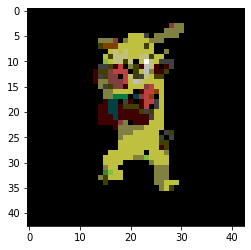

In [34]:
plt.imshow(images[1])
tp_dict = {}

# for every type/pred
for i in range(len(types)):
    t = types[i]
    pred = preds[i]
    if t not in omit_list:
        tp_dict[t] = pred[1][1]
tp_dict = {k: v for k, v in sorted(tp_dict.items(), key=lambda item: item[1])}

total = 0
for key, val in tp_dict.items():
    total+=val

for key in reversed(list(tp_dict.keys())):
    print("%s: %f"%(key,tp_dict[key]/total))
    
top2types = list(tp_dict.keys())[-2:]

print(top2types)

In [44]:
total_types = 0
total_correct = 0
for j in range(len(gen8_types_data)):
    tp_dict = {}

    # for every type/pred
    for i in range(len(types)):
        t = types[i]
        pred = preds[i]
        if t not in omit_list:
            tp_dict[t] = pred[j][1]
    tp_dict = {k: v for k, v in sorted(tp_dict.items(), 
                                       key=lambda item: item[1])}

    total = 0
    for key, val in tp_dict.items():
        total+=val

    for key, val in tp_dict.items():
        tp_dict[key] = val/total
    
    top2types = list(tp_dict.keys())[-2:]
    
    poke_types = []
    for t in types:
        if gen8_types_data[t][j] == 1 and t not in omit_list:
            poke_types.append(t)
    
    if len(poke_types) == 2:
        for t in poke_types:
            if t in top2types:
                total_correct+=1
            total_types+=1
    elif len(poke_types) == 1:
        if poke_types[0] == top2types[1]:
            total_correct+=1
        total_types+=1
            
print("1-2 Type Accuracy: %f"%(total_correct/total_types))

Accuracy: 0.329114
